In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/dev/python/foundation


In [3]:
from src.main.core import Tensor
from src.main.visualisation import draw_dot

In [4]:
a = Tensor(data=2.0)
b = Tensor(data=-3.0)
c = Tensor(data=10.0)

d = a * b + c
d

Tensor(data=4.0)

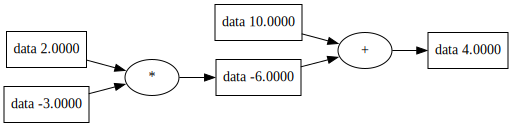

In [5]:
draw_dot(d)